# Data from Angeles Point (Station 46267), Neah Bay (Station 46087), and Cape Elizabeth (Station 46041)

This code: 

*   Loads data from Angeles Point, Neah Bay, and Cape Elizabeth
*   Runs linear regressions for WVHT and MWD from Neah Bay and Cape Elizabeth
*   Adjusts Cape Elizabeth data using linear regression equations and fills in Neah Bay data gaps using Cape Elizabeth data
*   Plots WVHT, DPD, and MWD
*   Calculates wavelength, maximum orbital-wave velocity, and bed shear stress for Neah Bay
*   Calculates wavelength, WVHT, DPD, maximum orbital-wave velocity, and bed shear stress to create a long term wave time series for Angeles Point using wave data from Neah Bay


WVHT = significant wave height (m)

DPD = dominant wave period (sec)

MWD = direction that waves are coming from (degrees)










In [43]:
# Import NumPy, xarray, Matplotlib (and related imports)
import os
import glob    
import numpy as np
import pandas as pd
import xarray as xr
import matplotlib.pyplot as plt
from matplotlib.dates import DateFormatter
import matplotlib.dates as mdates
from datetime import datetime, timedelta
from dateutil import parser as date_parser
import seaborn as sns
from scipy import stats 
import scipy.stats as linregress
import statsmodels.api as sm
import math

# Give Colab access to Google Drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [44]:
angeles_point = '/content/drive/MyDrive/Elwha project/Angeles Point (full time series).txt'
neah_bay_ofour = '/content/drive/MyDrive/Elwha project/Neah Bay (2004).txt'
neah_bay_two = '/content/drive/MyDrive/Elwha project/Neah Bay (2005-Jan 2008).txt'
neah_bay_rest = '/content/drive/MyDrive/Elwha project/Neah Bay (2008-2020).txt'
elizabeth_ofour = '/content/drive/MyDrive/Elwha project/Cape Elizabeth (2004).txt'
elizabeth_two = '/content/drive/MyDrive/Elwha project/Cape Elizabeth (2005-Jan 2008).txt'
elizabeth_rest = '/content/drive/MyDrive/Elwha project/Cape Elizabeth (2008-2020).txt'

def clean_line(line):
  line_list = line.split(' ')
  line_list[-1] = line_list[-1].replace("\n", "")
  line_list = [i for i in line_list if i]
  return line_list                 # Remove spaces between values

def get_header(path):
  with open(path, 'r') as fp:
    h_full = []
    h1 = clean_line(fp.readline())
    h2 = clean_line(fp.readline())
    for e1, e2 in zip(h1, h2):
      h_full.append(f'{e1} {e2}')   # Combine two header lines into 1 line
    return h_full

def load_dataframe(path, header):
  with open(path, 'r') as fp:
    fp.readline()
    fp.readline()
    data = []
    for i, line in enumerate(fp):
      line_list = clean_line(line)
      data.append(line_list)
  return pd.DataFrame(data, columns=header)


def format_dataframe(df):
  df = df.rename(columns={'#YY #yr': 'Year', 'MM mo': 'Month', 'DD dy': 'Day', 'hh hr': 'Hour', 'mm mn': 'Minute'})
  df.loc[:, ['Year', 'Month', 'Day', 'Hour', 'Minute']] = df.loc[:, ['Year', 'Month', 'Day', 'Hour', 'Minute']].astype(int)
  df = df.astype({'WDIR degT': int, 'WSPD m/s': float, 'GST m/s': float, 'WVHT m': float, 'DPD sec': float, 'APD sec': float, 'MWD degT': int, 'PRES hPa': float, 'ATMP degC': float, 'WTMP degC': float, 'DEWP degC': float, 'VIS mi':float, 'TIDE ft': float})
  df = df.replace(to_replace={99: np.NaN, 999: np.NaN}) # Replace 99.0 and 999.0 with NaN
  return df

def format_dataframe_neahbay_ofour(df):
  df = df.rename(columns={'#YY #yr': 'Year', 'MM mo': 'Month', 'DD dy': 'Day', 'hh hr': 'Hour'})
  df.loc[:, ['Year', 'Month', 'Day', 'Hour']] = df.loc[:, ['Year', 'Month', 'Day', 'Hour']].astype(int)
  df = df.astype({'WDIR degT': int, 'WSPD m/s': float, 'GST m/s': float, 'WVHT m': float, 'DPD sec': float, 'APD sec': float, 'MWD degT': int, 'PRES hPa': float, 'ATMP degC': float, 'WTMP degC': float, 'DEWP degC': float, 'VIS mi':float, 'TIDE ft': float})
  df = df.replace(to_replace={99: np.NaN, 999: np.NaN})
  return df

def get_date(year, month, day, hour, min):
  return f"{year}-{month}-{day} {hour}:{min}"

def get_date_month_day(month, day):
  return f"{month}-{day}"
  

In [45]:
# Angeles Point DataFrame
angeles_df = load_dataframe(angeles_point, get_header(angeles_point))
angeles_df = format_dataframe(angeles_df)
# angeles_df['WVHT m'].where(angeles_df['WVHT m'] <= 3, np.NaN, inplace=True) # Replace wave height values above 3 with NaN

# Combine year month, etc into date col. Change date column from object/string into datetime
angeles_df['Date'] = angeles_df[['Year', 'Month', 'Day', 'Hour', 'Minute']].astype(str).apply(lambda x: get_date(x.Year, x.Month, x.Day, x.Hour, x.Minute), axis=1)
date_col = angeles_df.pop('Date')
angeles_df.insert(0, "Date", date_col)
angeles_df.loc[:,'Date'] = pd.to_datetime(angeles_df['Date'], format='%Y-%m-%d %H:%M')

# Fill missing rows with NaNs. Frequency is '30T' which is every 30 minutes.
angeles_df.index = angeles_df['Date']
angeles_df.drop(columns=['Date','Year','Month','Day','Hour','Minute'], inplace = True)
angeles_missing_dates = pd.Series(index=pd.date_range(angeles_df.index.min(), angeles_df.index.max(), freq='30T')\
              .difference(angeles_df.index))
angeles_df = pd.concat([angeles_df, angeles_missing_dates]).sort_index()
angeles_df.index = pd.to_datetime(angeles_df.index)
angeles_df

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  app.launch_new_instance()


,0,APD sec,ATMP degC,DEWP degC,DPD sec,GST m/s,MWD degT,PRES hPa,TIDE ft,VIS mi,WDIR degT,WSPD m/s,WTMP degC,WVHT m
2020-04-01 19:00:00,NaN,3.16,NaN,NaN,10.53,NaN,300.0,9999.0,NaN,NaN,NaN,NaN,7.9,0.54
2020-04-01 19:30:00,NaN,3.08,NaN,NaN,10.00,NaN,291.0,9999.0,NaN,NaN,NaN,NaN,7.8,0.46
2020-04-01 20:00:00,NaN,3.18,NaN,NaN,10.53,NaN,306.0,9999.0,NaN,NaN,NaN,NaN,8.0,0.39
2020-04-01 20:30:00,NaN,2.99,NaN,NaN,11.11,NaN,301.0,9999.0,NaN,NaN,NaN,NaN,8.0,0.34
2020-04-01 21:00:00,NaN,3.91,NaN,NaN,11.11,NaN,294.0,9999.0,NaN,NaN,NaN,NaN,8.0,0.33
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-12-31 21:30:00,NaN,5.88,NaN,NaN,10.00,NaN,293.0,9999.0,NaN,NaN,NaN,NaN,7.6,1.16
2021-12-31 22:00:00,NaN,5.68,NaN,NaN,9.52,NaN,292.0,9999.0,NaN,NaN,NaN,NaN,7.6,1.02
2021-12-31 22:30:00,NaN,5.75,NaN,NaN,11.11,NaN,295.0,9999.0,NaN,NaN,NaN,NaN,7.5,1.02
2021-12-31 23:00:00,NaN,6.22,NaN,NaN,11.11,NaN,294.0,9999.0,NaN,NaN,NaN,NaN,7.5,0.85


In [46]:
# Neah Bay Dataframe

# Neah Bay 2004 DataFrame 
#   Data collected every hour
neah_one = load_dataframe(neah_bay_ofour, get_header(neah_bay_ofour))
neah_one = format_dataframe_neahbay_ofour(neah_one)

# Combine year, month, etc, into date column. Change date column from object/string into datetime
neah_one['Minute'] = 0
neah_one['Date'] = neah_one[['Year', 'Month', 'Day', 'Hour', 'Minute']].astype(str).apply(lambda x: get_date(x.Year, x.Month, x.Day, x.Hour, x.Minute), axis=1)
date_col = neah_one.pop('Date')
neah_one.insert(0, "Date", date_col)
neah_one.loc[:,'Date'] = pd.to_datetime(neah_one['Date'], format='%Y-%m-%d %H:%M')

# Neah Bay 2005-Jan 2008 DataFrame
#   Data collected every 30 minutes
neah_two = load_dataframe(neah_bay_two, get_header(neah_bay_two))
neah_two = format_dataframe(neah_two)

# Combine year, month, etc, into date column. Change date column from object/string into datetime
neah_two['Date'] = neah_two[['Year', 'Month', 'Day', 'Hour', 'Minute']].astype(str).apply(lambda x: get_date(x.Year, x.Month, x.Day, x.Hour, x.Minute), axis=1)
date_col = neah_two.pop('Date')
neah_two.insert(0, "Date", date_col)
neah_two.loc[:,'Date'] = pd.to_datetime(neah_two['Date'], format='%Y-%m-%d %H:%M')

# Neah Bay 2008-2020 DataFrame
#   Data collected every 50 min and 20 min--> changed to 0 min and 30 min
neah_rest = load_dataframe(neah_bay_rest, get_header(neah_bay_rest))
neah_rest = format_dataframe(neah_rest)

# Change the minute column to have "20" --> "30" and "50" --> "00"
def neah_minute_change(Minute):
  if Minute == 20:
    return 30
  elif Minute == 50:
    return 0
  else:
    return Minute

# For every 0 minute, increase the hour by 1
def neah_hour_change(row):
  if row.Minute == 0:
    return row.Hour + 1
  else:
    return row.Hour

# For every 24 hour, decrease the hour to 0
def neah_24hour_change(row24):
  if row24.Hour == 24:
    return row24.Hour - 24
  else:
    return row24.Hour

# For every 0 day and 0 minute, increase the day by 1. The last date of the month was manually changed to 00 so the code increases the month by 1
def neah_day_change(day):
  if day.Hour == 0 and day.Minute == 0:
    return day.Day + 1 
  else:
    return day.Day

# Apply Neah Minute, Hour, Day changes
neah_rest['Minute'] = neah_rest['Minute'].apply(neah_minute_change)
neah_rest['Hour'] = neah_rest.apply(lambda row: neah_hour_change(row), axis=1)
neah_rest['Hour'] = neah_rest.apply(lambda row24: neah_24hour_change(row24), axis=1)
neah_rest['Hour'] = neah_rest['Hour'].astype(int)
neah_rest['Day'] = neah_rest.apply(lambda day: neah_day_change(day), axis=1)
neah_rest['Day'] = neah_rest['Day'].astype(int)

# Combine year, month, etc, into date column. Change date column from object/string into datetime
neah_rest['Date'] = neah_rest[['Year', 'Month', 'Day', 'Hour', 'Minute']].astype(str).apply(lambda x: get_date(x.Year, x.Month, x.Day, x.Hour, x.Minute), axis=1)
date_col = neah_rest.pop('Date')
neah_rest.insert(0, "Date", date_col)
neah_rest.loc[:,'Date'] = pd.to_datetime(neah_rest['Date'], format='%Y-%m-%d %H:%M')

# Combine Neah Bay dataframes
frames = [neah_one, neah_two, neah_rest]
neah_combined = pd.concat(frames)

# Create datetime index from year, month, day, etc. columns
neah_combined.index = neah_combined['Date']
neah_combined.drop(columns=['Date','Year','Month','Day','Hour','Minute'], inplace = True)
neah_combined.index = pd.to_datetime(neah_combined.index)

# Drop rows where WVHT and MWD have NaNs
neah_combined = neah_combined.dropna(subset=['WVHT m','MWD degT'], how='all')

In [47]:
# Cape Elizabeth Dataframe

# Cape Elizabeth 2004
#   Data collected every hour
elizabeth_ofour_df = load_dataframe(elizabeth_ofour, get_header(elizabeth_ofour))
elizabeth_ofour_df = format_dataframe_neahbay_ofour(elizabeth_ofour_df)

# Combine year, month, etc, into date column. Change date column from object/string into datetime
elizabeth_ofour_df['Minute'] = 0
elizabeth_ofour_df['Date'] = elizabeth_ofour_df[['Year', 'Month', 'Day', 'Hour', 'Minute']].astype(str).apply(lambda x: get_date(x.Year, x.Month, x.Day, x.Hour, x.Minute), axis=1)
date_col = elizabeth_ofour_df.pop('Date')
elizabeth_ofour_df.insert(0, "Date", date_col)
elizabeth_ofour_df.loc[:,'Date'] = pd.to_datetime(elizabeth_ofour_df['Date'], format='%Y-%m-%d %H:%M')

# Cape Elizabeth 2005-Jan 2008
#   Data collected every hour
elizabeth_two_df = load_dataframe(elizabeth_two, get_header(elizabeth_two))
elizabeth_two_df = format_dataframe(elizabeth_two_df)

# Combine year, month, etc, into date column. Change date column from object/string into datetime
elizabeth_two_df['Date'] = elizabeth_two_df[['Year', 'Month', 'Day', 'Hour', 'Minute']].astype(str).apply(lambda x: get_date(x.Year, x.Month, x.Day, x.Hour, x.Minute), axis=1)
date_col = elizabeth_two_df.pop('Date')
elizabeth_two_df.insert(0, "Date", date_col)
elizabeth_two_df.loc[:,'Date'] = pd.to_datetime(elizabeth_two_df['Date'], format='%Y-%m-%d %H:%M')

# Cape Elizabeth 2008-2020 DataFrame
#   From 2008-01-31 to 2020-05-23: data collected at 50 min once per hour --> changed 50 min to 0 min
#   From 2020-05-23 to 2020-12-31: data collected at 40 min once per hour --> changed 40 min to 30 min
elizabeth_rest_df = load_dataframe(elizabeth_rest, get_header(elizabeth_rest))
elizabeth_rest_df = format_dataframe(elizabeth_rest_df)

# Combine year, month, etc, into date column. Change date column from object/string into datetime
elizabeth_rest_df['Date'] = elizabeth_rest_df[['Year', 'Month', 'Day', 'Hour', 'Minute']].astype(str).apply(lambda x: get_date(x.Year, x.Month, x.Day, x.Hour, x.Minute), axis=1)
date_col = elizabeth_rest_df.pop('Date')
elizabeth_rest_df.insert(0, "Date", date_col)
elizabeth_rest_df.loc[:,'Date'] = pd.to_datetime(elizabeth_rest_df['Date'], format='%Y-%m-%d %H:%M')

# Drop rows where WVHT and MWD have NaNs
elizabeth_rest_df = elizabeth_rest_df.dropna(subset=['WVHT m','MWD degT'], how='all')

# Select last row of each month (where hour = 23 and minute=50)
eliz_month_last = elizabeth_rest_df.groupby([elizabeth_rest_df['Date'].dt.year, elizabeth_rest_df['Date'].dt.month], as_index=False).last()
eliz_month_last.drop(eliz_month_last.loc[eliz_month_last['Minute'] != 50].index, inplace=True) # Delete rows where Minute is not 50

# Change the minute column to have "50" --> "00"
def eliz_minute_change(Minute):
  if Minute == 50:
    return 00
  else:
    return Minute

# For every 23 hour, decrease the hour to 0
def eliz_24hour_change(row24):
  if row24.Hour == 23:
    return row24.Hour - 23
  else:
    return row24.Hour

# Change day to 1 (1st of Month)
eliz_month_last['Day']= 1

# Increase year by 1 if month is 12
def eliz_year_change(year):
  if year.Month == 12:
    return year.Year + 1 
  else:
    return year.Year

# Increase month by 1 (if 12th month, then change to 1)
def eliz_month_change(month):
  if month.Month == 12:
    return 1
  else:
    return month.Month + 1

# Apply Eliz Minute, Hour, Day changes
eliz_month_last['Minute'] = eliz_month_last['Minute'].apply(eliz_minute_change)
eliz_month_last['Hour'] = eliz_month_last.apply(lambda row24: eliz_24hour_change(row24), axis=1)
eliz_month_last['Year'] = eliz_month_last.apply(lambda year: eliz_year_change(year), axis=1)
eliz_month_last['Month'] = eliz_month_last.apply(lambda month: eliz_month_change(month), axis=1)

eliz_month_last.index = eliz_month_last['Date']
elizabeth_rest_df.index = elizabeth_rest_df['Date']

# Select last row of month
cond = elizabeth_rest_df['Date'].isin(eliz_month_last['Date'])
elizabeth_rest_df.drop(elizabeth_rest_df[cond].index, inplace = True)

# Change the minute column to have "40" --> "30" and "50" --> "00"
def elizabeth_minute_change(Minute):
  if Minute == 50:
    return 0
  elif Minute == 40:
    return 30
  else:
    return Minute

# For every 0 minute, increase the hour by 1
def elizabeth_hour_change(row):
  if row.Minute == 0:
    return row.Hour + 1
  else:
    return row.Hour

# For every 24 hour, decrease the hour to 0
def elizabeth_24hour_change(row24):
  if row24.Hour == 24:
    return row24.Hour - 24
  else:
    return row24.Hour

# For every 0 hour and 0 minute, increase the day by 1. 
def elizabeth_day_change(day):
  if day.Hour == 0 and day.Minute == 0:
    return day.Day + 1 
  else:
    return day.Day

# Apply ELizabeth Minute, Hour, Day changes
elizabeth_rest_df['Minute'] = elizabeth_rest_df['Minute'].apply(elizabeth_minute_change)
elizabeth_rest_df['Hour'] = elizabeth_rest_df.apply(lambda row: elizabeth_hour_change(row), axis=1)
elizabeth_rest_df['Hour'] = elizabeth_rest_df.apply(lambda row24: elizabeth_24hour_change(row24), axis=1)
elizabeth_rest_df['Day'] = elizabeth_rest_df.apply(lambda day: elizabeth_day_change(day), axis=1)

elizabeth_rest_df.drop(columns=['Date'], inplace = True)
eliz_month_last.drop(columns=['Date'], inplace = True)

elizabeth_rest_df = pd.concat([elizabeth_rest_df, eliz_month_last]).sort_index()

elizabeth_rest_df.reset_index(inplace=True)
elizabeth_rest_df.drop(columns=['Date'], inplace = True)

elizabeth_rest_df['Date'] = elizabeth_rest_df[['Year', 'Month', 'Day', 'Hour', 'Minute']].astype(str).apply(lambda x: get_date(x.Year, x.Month, x.Day, x.Hour, x.Minute), axis=1)
date_col = elizabeth_rest_df.pop('Date')
elizabeth_rest_df.insert(0, "Date", date_col)
elizabeth_rest_df.loc[:,'Date'] = pd.to_datetime(elizabeth_rest_df['Date'], format='%Y-%m-%d %H:%M')

# Combine Cape Elizabeth dataframes
frames_eliz = [elizabeth_ofour_df, elizabeth_two_df, elizabeth_rest_df]
elizabeth_combined = pd.concat(frames_eliz)

# Create datetime index from year, month, day, etc. columns
elizabeth_combined.index = elizabeth_combined['Date']
elizabeth_combined.drop(columns=['Date','Year','Month','Day','Hour','Minute'], inplace = True)
elizabeth_combined.index = pd.to_datetime(elizabeth_combined.index)

# Dataframes from Cape Elizabeth to fill Neah Bay data gaps
elizabeth_gap1 = elizabeth_combined.loc['2009-11-20':'2011-04-12'] # 4.5 months
elizabeth_gap2 = elizabeth_combined.loc['2012-3-29':'2012-06-30'] # 3 months
elizabeth_gap3 = elizabeth_combined.loc['2013-05-03':'2013-10-03'] # 9 months
frames_gap = [elizabeth_gap1, elizabeth_gap2, elizabeth_gap3]
elizabeth_gap = pd.concat(frames_gap)

# Drop rows where WVHT and MWD have NaNs
elizabeth_combined = elizabeth_combined.dropna(subset=['WVHT m','MWD degT'], how='all')

# Select date range that is the same as Neah Bay
elizabeth_combined = elizabeth_combined.loc['2004-07-09':'2020-11-23 14:30:00']
elizabeth_combined

/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:4913: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


,WDIR degT,WSPD m/s,GST m/s,WVHT m,DPD sec,APD sec,MWD degT,PRES hPa,ATMP degC,WTMP degC,DEWP degC,VIS mi,TIDE ft
Date,,,,,,,,,,,,,
2004-07-09 00:00:00,261.0,4.2,5.0,1.61,14.29,7.11,274.0,1015.0,14.4,14.1,NaN,NaN,NaN
2004-07-09 01:00:00,293.0,4.5,5.4,1.48,8.33,6.77,294.0,1014.3,14.3,13.6,NaN,NaN,NaN
2004-07-09 02:00:00,322.0,3.9,4.7,1.42,8.33,6.72,296.0,1013.9,13.7,13.6,NaN,NaN,NaN
2004-07-09 03:00:00,331.0,5.5,6.4,1.41,14.29,6.93,275.0,1013.3,13.6,13.4,NaN,NaN,NaN
2004-07-09 04:00:00,324.0,3.4,3.9,1.43,14.29,7.18,281.0,1013.2,13.4,13.4,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-11-23 10:30:00,167.0,10.2,13.7,2.68,14.81,6.55,270.0,1009.5,NaN,9.8,NaN,NaN,NaN
2020-11-23 11:30:00,297.0,11.4,13.8,2.89,13.79,7.28,286.0,1009.7,NaN,9.9,NaN,NaN,NaN
2020-11-23 12:30:00,310.0,10.7,14.5,2.59,12.90,6.60,280.0,1010.7,NaN,9.9,NaN,NaN,NaN


In [48]:
# Dataframes to test similarity between Cape Elizabeth and Neah Bay
# Chose to compare 2009, 2016, and 2020
elizabeth_2009 = elizabeth_combined.loc['2009-01-01':'2009-12-31']
elizabeth_2016 = elizabeth_combined.loc['2016-01-01':'2016-12-31']
elizabeth_2020 = elizabeth_combined.loc['2020-01-01':'2020-12-31']

neah_2009 = neah_combined.loc['2009-01-01':'2009-12-31']
neah_2016 = neah_combined.loc['2016-01-01':'2016-12-31']
neah_2020 = neah_combined.loc['2020-01-01':'2020-12-31']

# Cape Elizabeth fill in missing rows with NaNs
elizabeth_2009 = elizabeth_2009.dropna(subset=['WVHT m','MWD degT'], how='all')
elizabeth_2009_missing_dates = pd.Series(index=pd.date_range(elizabeth_2009.index.min(), elizabeth_2009.index.max(), freq='30T')\
              .difference(elizabeth_2009.index))
elizabeth_2009 = pd.concat([elizabeth_2009, elizabeth_2009_missing_dates]).sort_index()

elizabeth_2016 = elizabeth_2016.dropna(subset=['WVHT m','MWD degT'], how='all')
elizabeth_2016_missing_dates = pd.Series(index=pd.date_range(elizabeth_2016.index.min(), elizabeth_2016.index.max(), freq='30T')\
              .difference(elizabeth_2016.index))
elizabeth_2016 = pd.concat([elizabeth_2016, elizabeth_2016_missing_dates]).sort_index()

elizabeth_2020 = elizabeth_2020.dropna(subset=['WVHT m','MWD degT'], how='all')
elizabeth_2020_missing_dates = pd.Series(index=pd.date_range(elizabeth_2020.index.min(), elizabeth_2020.index.max(), freq='30T')\
              .difference(elizabeth_2020.index))
elizabeth_2020 = pd.concat([elizabeth_2020, elizabeth_2020_missing_dates]).sort_index()


# Neah Bay fill in missing rows with NaNs
neah2008_missing_dates = pd.Series(index=pd.date_range(neah_2009.index.min(), neah_2009.index.max(), freq='30T')\
              .difference(neah_2009.index))
neah_2009 = pd.concat([neah_2009, neah2008_missing_dates]).sort_index()

neah2016_missing_dates = pd.Series(index=pd.date_range(neah_2016.index.min(), neah_2016.index.max(), freq='30T')\
              .difference(neah_2016.index))
neah_2016 = pd.concat([neah_2016, neah2016_missing_dates]).sort_index()

neah2020_missing_dates = pd.Series(index=pd.date_range(neah_2020.index.min(), neah_2020.index.max(), freq='30T')\
              .difference(neah_2020.index))
neah_2020 = pd.concat([neah_2020, neah2020_missing_dates]).sort_index()
neah_2020 = neah_2020.dropna(subset=['WVHT m','MWD degT'], how='all')

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:14: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:19: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:24: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:30: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:34: Deprecat

2009 R2: 0.8036537384943143 2016 R2: 0.8091482111661006 2020 R2: 0.8350962952303411


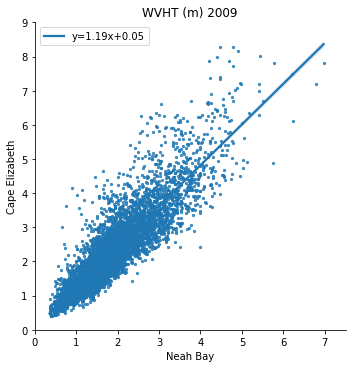

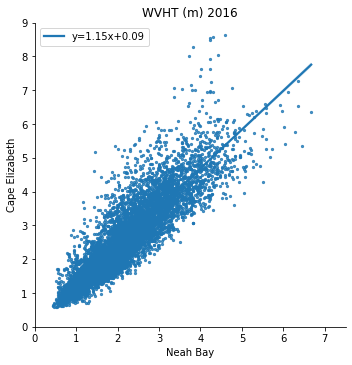

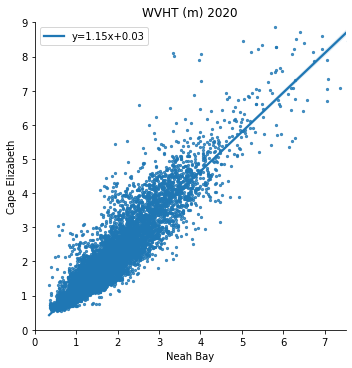

In [49]:
# Linear regressions for WVHT from 2009, 2016, and 2020
# Select same rows for Angeles Point WVHT as selected previously for Neah Bay, and create new dataframe.
one_wvht_df = pd.concat([elizabeth_2009['WVHT m'],neah_2009['WVHT m']], axis=1)
two_wvht_df = pd.concat([elizabeth_2016['WVHT m'],neah_2016['WVHT m']], axis=1)
three_wvht_df = pd.concat([elizabeth_2020['WVHT m'],neah_2020['WVHT m']], axis=1)

one_wvht_df.columns.values[0]='Cape Elizabeth WVHT m'
one_wvht_df.columns.values[1]='Neah Bay WVHT m'
two_wvht_df.columns.values[0]='Cape Elizabeth WVHT m'
two_wvht_df.columns.values[1]='Neah Bay WVHT m'
three_wvht_df.columns.values[0]='Cape Elizabeth WVHT m'
three_wvht_df.columns.values[1]='Neah Bay WVHT m'

# Drop the NaNs so the linear regression works
one_wvht_df = one_wvht_df.dropna()
two_wvht_df = two_wvht_df.dropna()
three_wvht_df = three_wvht_df.dropna()

# Section 1. get coeffs of linear fit
slope_one, intercept_one, r_value_one, p_value_one, std_err_one = stats.linregress(one_wvht_df['Neah Bay WVHT m'],one_wvht_df['Cape Elizabeth WVHT m'])

p = sns.lmplot(x='Neah Bay WVHT m', y='Cape Elizabeth WVHT m', data=one_wvht_df, scatter_kws={"s": 5}, line_kws={'label':"Linear Reg"}, legend=True)
p.set(ylim=(0,9), xlim=(0,7.5), title='WVHT (m) 2009', xlabel='Neah Bay', ylabel='Cape Elizabeth')
ax = p.axes[0, 0]
ax.legend(loc='upper left')
leg = ax.get_legend()
L_labels = leg.get_texts()
label_line_1 = r'y={0:.2f}x+{1:.2f}'.format(slope_one,intercept_one)
label_line_2 = r'$R^2:{0:.2f}$'.format(r_value_one**2) 
L_labels[0].set_text(label_line_1)
# L_labels[-1].set_text(label_line_2)

# Section 2
slope_two, intercept_two, r_value_two, p_value_two, std_err_two = stats.linregress(two_wvht_df['Neah Bay WVHT m'],two_wvht_df['Cape Elizabeth WVHT m'])

p = sns.lmplot(x='Neah Bay WVHT m', y='Cape Elizabeth WVHT m', data=two_wvht_df, scatter_kws={"s": 5}, line_kws={'label':"Linear Reg"}, legend=True)
p.set(ylim=(0,9), xlim=(0,7.5), title='WVHT (m) 2016', xlabel='Neah Bay', ylabel='Cape Elizabeth')
ax = p.axes[0, 0]
ax.legend(loc='upper left')
leg = ax.get_legend()
L_labels = leg.get_texts()
label_line_1 = r'y={0:.2f}x+{1:.2f}'.format(slope_two,intercept_two)
label_line_2 = r'$R^2:{0:.2f}$'.format(r_value_two**2) 
L_labels[0].set_text(label_line_1)

# Section 3. 
slope_three, intercept_three, r_value_three, p_value_three, std_err_three = stats.linregress(three_wvht_df['Neah Bay WVHT m'],three_wvht_df['Cape Elizabeth WVHT m'])

p = sns.lmplot(x='Neah Bay WVHT m', y='Cape Elizabeth WVHT m', data=three_wvht_df, scatter_kws={"s": 5}, line_kws={'label':"Linear Reg"}, legend=True)
p.set(ylim=(0,9), xlim=(0,7.5), title='WVHT (m) 2020', xlabel='Neah Bay', ylabel='Cape Elizabeth')
ax = p.axes[0, 0]
ax.legend(loc='upper left')
leg = ax.get_legend()
L_labels = leg.get_texts()
label_line_1 = r'y={0:.2f}x+{1:.2f}'.format(slope_three,intercept_three)
label_line_2 = r'$R^2:{0:.2f}$'.format(r_value_three**2) 
L_labels[0].set_text(label_line_1)
# L_labels[1].set_text(label_line_2)

print('2009 R2:', r_value_one**2, '2016 R2:', r_value_two**2,'2020 R2:',r_value_three**2)

'r squared:'

0.7946579719865303

0.0

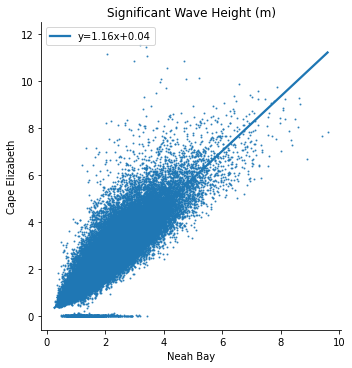

In [50]:
# Linear regression for all WVHT data
eliz_copy = elizabeth_combined.copy()
neah_copy = neah_combined.copy()

wvht_df = pd.merge(neah_copy['WVHT m'], eliz_copy['WVHT m'], left_index=True, right_index=True)

# Dataframe
wvht_df.columns.values[0]='Neah Bay WVHT m'
wvht_df.columns.values[1]='Cape Elizabeth WVHT m'

wvht_df = wvht_df.dropna()

# Stats
slope, intercept, r_value_ok, p_value_ok, std_err = stats.linregress(wvht_df['Neah Bay WVHT m'],wvht_df['Cape Elizabeth WVHT m'])

# Plot
p = sns.lmplot(x='Neah Bay WVHT m',y='Cape Elizabeth WVHT m', data=wvht_df, fit_reg=True, scatter_kws={"s": 1},line_kws={'label':"Linear Reg"}, height=5, legend=True)# truncate=False) 
p.set(title='Significant Wave Height (m)', xlabel='Neah Bay', ylabel='Cape Elizabeth')
ax = p.axes[0, 0]
ax.legend(loc='upper left')
leg = ax.get_legend()
L_labels = leg.get_texts()
label_line_1 = r'y={0:.2f}x+{1:.2f}'.format(slope,intercept)
label_line_2 = r'$R^2:{0:.2f}$'.format(r_value_ok**2) 
L_labels[0].set_text(label_line_1)
# L_labels[-1].set_text(label_line_2)

display('r squared:',r_value_ok**2)
display(p_value_ok)
# wvht_df


In [51]:
# Cape Elizabeth and Neah Bay WVHT m data have high R^2. Adjust the Cape Elizabeth to better fit the Neah Bay data using the linear regression equation 
elizabeth_gap['WVHT m'] = (elizabeth_gap['WVHT m'] / 1.16)+0.04
elizabeth_gap

,WDIR degT,WSPD m/s,GST m/s,WVHT m,DPD sec,APD sec,MWD degT,PRES hPa,ATMP degC,WTMP degC,DEWP degC,VIS mi,TIDE ft
Date,,,,,,,,,,,,,
2009-11-20 00:00:00,NaN,18.4,22.2,4.953793,11.43,7.87,160.0,997.5,11.2,11.3,NaN,NaN,NaN
2009-11-20 01:00:00,NaN,18.9,23.8,5.255517,11.43,7.99,167.0,996.9,11.6,11.3,NaN,NaN,NaN
2009-11-20 02:00:00,NaN,16.6,21.4,5.272759,11.43,7.72,167.0,997.5,11.2,11.3,NaN,NaN,NaN
2009-11-20 03:00:00,NaN,18.4,22.6,5.548621,10.00,7.91,157.0,996.2,11.6,11.3,NaN,NaN,NaN
2009-11-20 04:00:00,NaN,16.3,20.8,5.427931,11.43,7.91,157.0,996.4,11.5,11.3,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2013-10-03 19:00:00,NaN,3.6,5.2,1.652069,10.81,7.85,NaN,1028.7,NaN,13.9,NaN,NaN,NaN
2013-10-03 20:00:00,NaN,2.7,4.0,1.772759,11.43,8.20,NaN,1029.2,NaN,13.9,NaN,NaN,NaN
2013-10-03 21:00:00,NaN,2.4,3.6,1.738276,12.12,8.26,NaN,1029.0,NaN,14.0,NaN,NaN,NaN


2009 R2: 0.33204904879739494 2016 R2: 0.2952337014372105 2020 R2: 0.17456862774808196


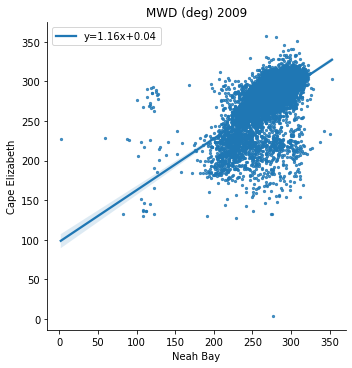

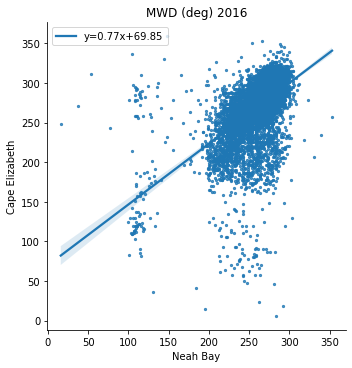

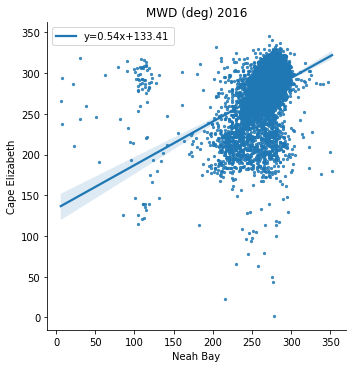

In [52]:
# Linear regressions for MWD from 2009, 2016, and 2020
# Select same rows for Angeles Point MWD as selected previously for Neah Bay, and create new dataframe.
one_mwd_df = pd.concat([elizabeth_2009['MWD degT'],neah_2009['MWD degT']], axis=1)
two_mwd_df = pd.concat([elizabeth_2016['MWD degT'],neah_2016['MWD degT']], axis=1)
three_mwd_df = pd.concat([elizabeth_2020['MWD degT'],neah_2020['MWD degT']], axis=1)

one_mwd_df.columns.values[0]='Cape Elizabeth MWD degT'
one_mwd_df.columns.values[1]='Neah Bay MWD degT'
two_mwd_df.columns.values[0]='Cape Elizabeth MWD degT'
two_mwd_df.columns.values[1]='Neah Bay MWD degT'
three_mwd_df.columns.values[0]='Cape Elizabeth MWD degT'
three_mwd_df.columns.values[1]='Neah Bay MWD degT'

# Drop the NaNs so the linear regression works
one_mwd_df = one_mwd_df.dropna()
two_mwd_df = two_mwd_df.dropna()
three_mwd_df = three_mwd_df.dropna()

# Section 1. get coeffs of linear fit
slope_one, intercept_one, r_value, p_value, std_err_one = stats.linregress(one_mwd_df['Neah Bay MWD degT'],one_mwd_df['Cape Elizabeth MWD degT'])

p = sns.lmplot(x='Neah Bay MWD degT', y='Cape Elizabeth MWD degT', data=one_mwd_df, scatter_kws={"s": 5}, line_kws={'label':"Linear Reg"}, legend=True)
p.set(title='MWD (deg) 2009', xlabel='Neah Bay', ylabel='Cape Elizabeth')
ax = p.axes[0, 0]
ax.legend(loc='upper left')
leg = ax.get_legend()
L_labels = leg.get_texts()
label_line_1 = r'y={0:.2f}x+{1:.2f}'.format(slope,intercept)
label_line_2 = r'$R^2:{0:.2f}$'.format(r_value**2) 
L_labels[0].set_text(label_line_1)
# L_labels[1].set_text(label_line_2)

# Section 2
slope_two, intercept_two, r_value_two, p_value_two, std_err_two = stats.linregress(two_mwd_df['Neah Bay MWD degT'],two_mwd_df['Cape Elizabeth MWD degT'])

p = sns.lmplot(x='Neah Bay MWD degT', y='Cape Elizabeth MWD degT', data=two_mwd_df, scatter_kws={"s": 5}, line_kws={'label':"Linear Reg"}, legend=True)
p.set(title='MWD (deg) 2016', xlabel='Neah Bay', ylabel='Cape Elizabeth')
ax = p.axes[0, 0]
ax.legend(loc='upper left')
leg = ax.get_legend()
L_labels = leg.get_texts()
label_line_1 = r'y={0:.2f}x+{1:.2f}'.format(slope_two,intercept_two)
label_line_2 = r'$R^2:{0:.2f}$'.format(r_value_two**2) 
L_labels[0].set_text(label_line_1)

# Section 3
slope_three, intercept_three, r_value_three, p_value_three, std_err_three = stats.linregress(three_mwd_df['Neah Bay MWD degT'],three_mwd_df['Cape Elizabeth MWD degT'])

p = sns.lmplot(x='Neah Bay MWD degT', y='Cape Elizabeth MWD degT', data=three_mwd_df, scatter_kws={"s": 5}, line_kws={'label':"Linear Reg"}, legend=True)
p.set(title='MWD (deg) 2016', xlabel='Neah Bay', ylabel='Cape Elizabeth')
ax = p.axes[0, 0]
ax.legend(loc='upper left')
leg = ax.get_legend()
L_labels = leg.get_texts()
label_line_1 = r'y={0:.2f}x+{1:.2f}'.format(slope_three,intercept_three)
label_line_2 = r'$R^2:{0:.2f}$'.format(r_value_three**2) 
L_labels[0].set_text(label_line_1)

print('2009 R2:', r_value**2, '2016 R2:', r_value_two**2, '2020 R2:', r_value_three**2)

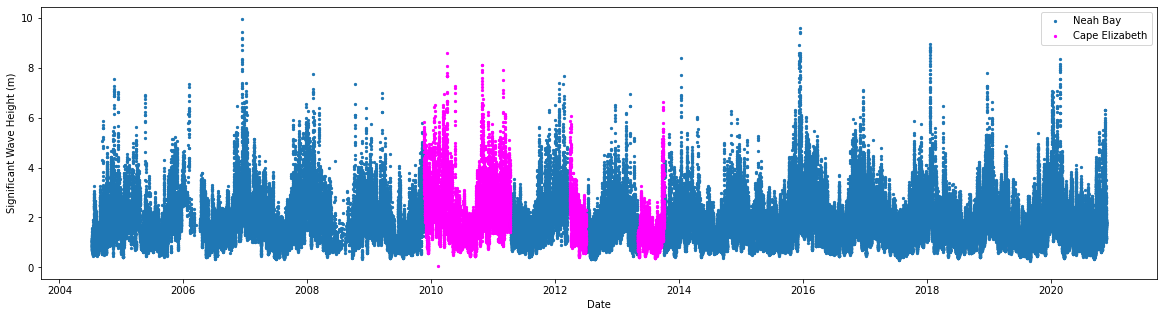

In [53]:
# Plot significant wave height

# Neah Bay
fig, ax1 = plt.subplots(figsize=(20,5))
ax1.set(xlabel='Date',
       ylabel='Significant Wave Height (m)')
ax1.scatter(x=neah_combined.index, y=neah_combined['WVHT m'], s=5)

# Cape Elizabeth
ax1.set(xlabel='Date',
       ylabel='Significant Wave Height (m)')
ax1.scatter(x=elizabeth_gap.index, y=elizabeth_gap['WVHT m'], s=5, c='fuchsia')
ax1.legend(['Neah Bay','Cape Elizabeth'])


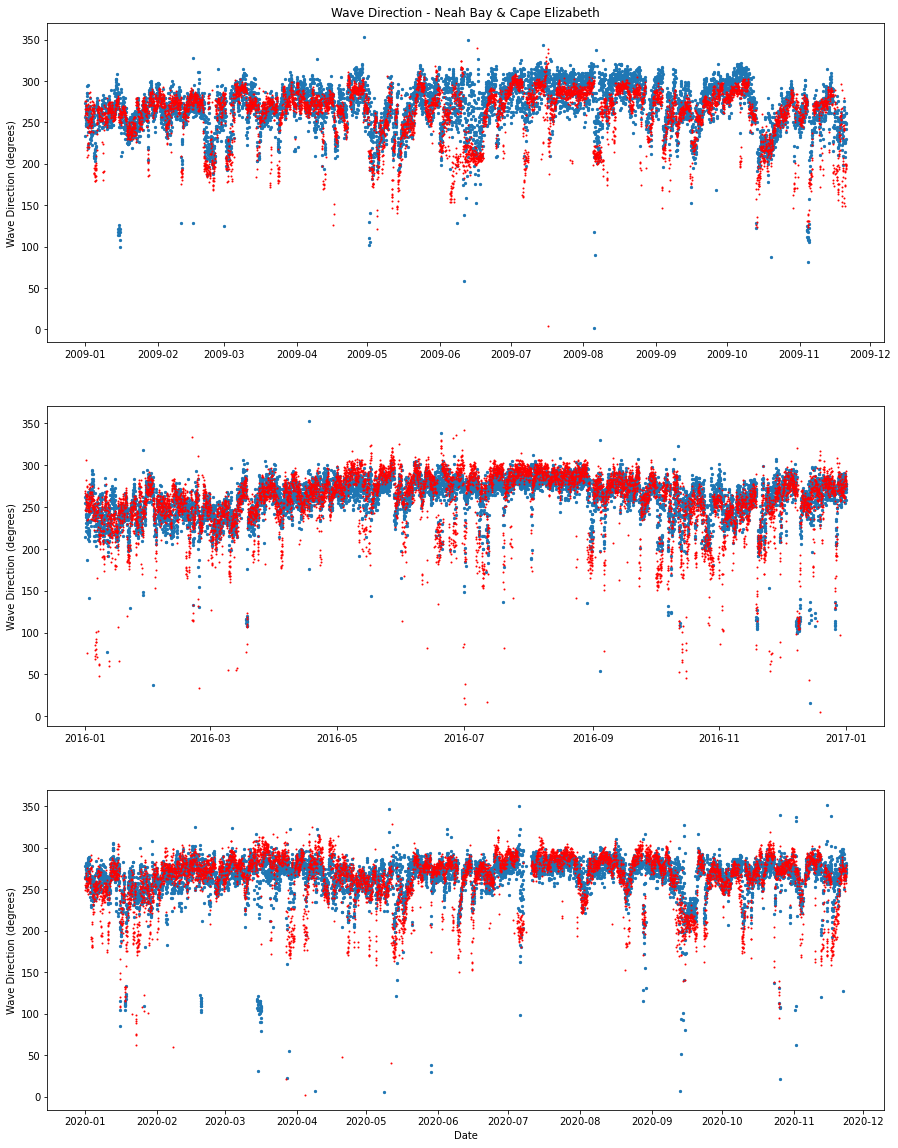

In [54]:
# Test to see if diving by 1.05 makes Neah Bay and Cape Elizabeth data line up better
one_test = one_mwd_df.copy()
two_test = two_mwd_df.copy()
three_test = three_mwd_df.copy()

one_test['Cape Elizabeth MWD degT'] = one_test['Cape Elizabeth MWD degT'] / 1.05
two_test['Cape Elizabeth MWD degT'] = two_test['Cape Elizabeth MWD degT']  / 1.05
three_test['Cape Elizabeth MWD degT'] = three_test['Cape Elizabeth MWD degT'] / 1.05

# Plot Wave direction
# 2009 Neah Bay
fig, (ax1, ax2, ax3) = plt.subplots(nrows=3, figsize=(15,20))
ax1.set(ylabel='Wave Direction (degrees)',
       title='Wave Direction - Neah Bay & Cape Elizabeth')
ax1.scatter(x=one_test.index, y=one_test['Neah Bay MWD degT'], s=5)

# 2009 Cape Elizabeth
ax1.scatter(x=one_test.index, y=one_test['Cape Elizabeth MWD degT'], s=1, c='r')

# 2016 Neah Bay
ax2.set(ylabel='Wave Direction (degrees)')
ax2.scatter(x=two_test.index, y=two_test['Neah Bay MWD degT'], s=5)

# 2016 Cape Elizabeth
ax2.scatter(x=two_test.index, y=two_test['Cape Elizabeth MWD degT'], s=1, c='r')

# 2020 Neah Bay
ax3.set(xlabel='Date',
       ylabel='Wave Direction (degrees)')
ax3.scatter(x=three_test.index, y=three_test['Neah Bay MWD degT'], s=5)

# 2020 Cape Elizabeth
ax3.scatter(x=three_test.index, y=three_test['Cape Elizabeth MWD degT'], s=1, c='r')

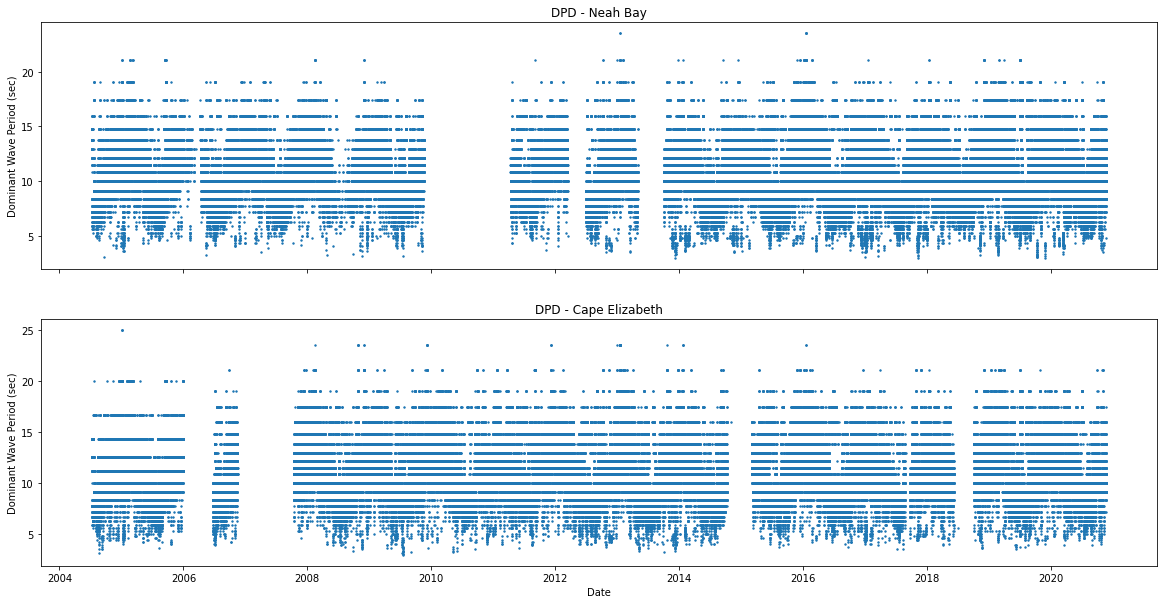

In [55]:
# Plot Dominant Wave Period

# Neah bay
fig, (ax1,ax2) = plt.subplots(nrows=2, sharex=True, figsize=(20, 10))
ax1.set(ylabel='Dominant Wave Period (sec)',
        title='DPD - Neah Bay')
ax1.scatter(x=neah_combined.index, y=neah_combined['DPD sec'], s=2)

# Cape ELizabeth
ax2.set(xlabel='Date',
       ylabel='Dominant Wave Period (sec)',
       title='DPD - Cape Elizabeth')
ax2.scatter(x=elizabeth_combined.index, y=elizabeth_combined['DPD sec'], s=2)

In [56]:
## Dividing by 1.05 is a small adjustment to make Neah Bay and Cape Elizabeth wave direction data line up better. 1.05 was chosen based on how data lines up visually. Not chosen based on statistics

# Adjust MWD for all Cape Elizabeth data
elizabeth_adj = elizabeth_combined.copy()
elizabeth_adj['MWD degT'] = elizabeth_adj['MWD degT'] / 1.05

# Adjust MWD for Cape ELizabeth data that fills Neah Bay data gaps
elizabeth_gap_adj = elizabeth_gap.copy()
elizabeth_gap_adj['MWD degT'] = elizabeth_gap_adj['MWD degT'] / 1.05

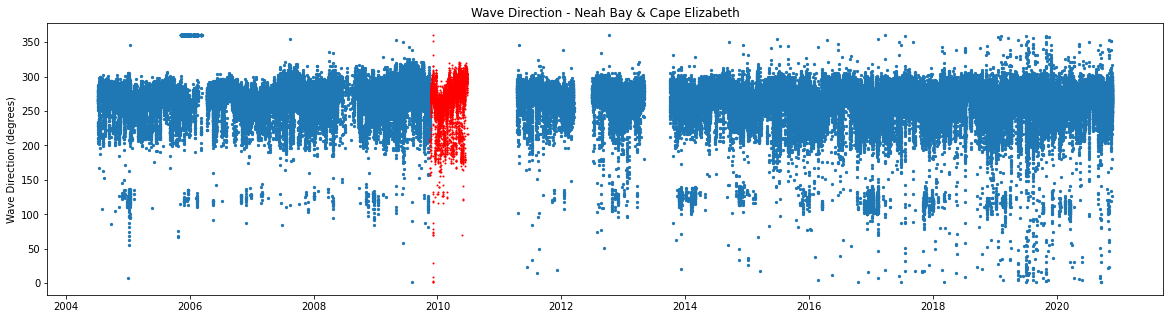

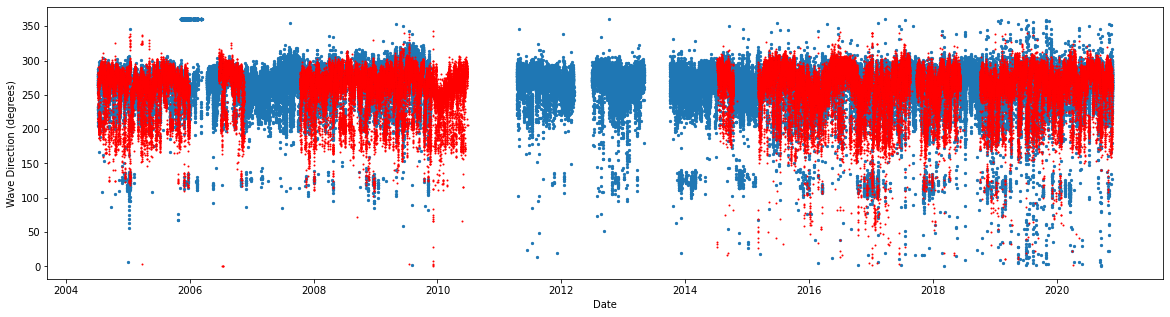

In [57]:
# Scatter wave direction

# Neah Bay
fig, ax1 = plt.subplots(figsize=(20,5))
ax1.scatter(x=neah_combined.index, y=neah_combined['MWD degT'], s=5)

# Cape Elizabeth (only data that fills in Neah Bay MWD data gap)
ax1.set(ylabel='Wave Direction (degrees)',
       title='Wave Direction - Neah Bay & Cape Elizabeth')
ax1.scatter(x=elizabeth_gap.index, y=elizabeth_gap['MWD degT'], s=1, c='r')

# Neah Bay
fig, ax1 = plt.subplots(figsize=(20,5))
ax1.scatter(x=neah_combined.index, y=neah_combined['MWD degT'], s=5)

# Cape Elizabeth (all Cape Elizabeth MWD data)
ax1.set(xlabel='Date',
       ylabel='Wave Direction (degrees)')
ax1.scatter(x=elizabeth_adj.index, y=elizabeth_adj['MWD degT'], s=1, c='r')


In [58]:
# Combine wave direction from Neah Bay and Cape Elizabeth
combined_adj = neah_combined.combine_first(elizabeth_gap_adj)
combined_adj.to_csv('combined_adj.csv')
combined_adj

,WDIR degT,WSPD m/s,GST m/s,WVHT m,DPD sec,APD sec,MWD degT,PRES hPa,ATMP degC,WTMP degC,DEWP degC,VIS mi,TIDE ft
Date,,,,,,,,,,,,,
2004-07-09 00:00:00,268.0,2.4,3.0,0.69,5.56,4.15,278.0,1015.8,12.0,11.4,11.4,NaN,NaN
2004-07-09 01:00:00,269.0,2.2,2.9,1.57,8.33,6.42,278.0,1015.0,11.6,11.3,11.1,NaN,NaN
2004-07-09 02:00:00,295.0,1.7,2.2,1.43,13.79,6.40,252.0,1014.4,11.6,11.8,11.1,NaN,NaN
2004-07-09 03:00:00,261.0,4.9,5.7,1.52,8.33,6.47,288.0,1014.1,11.9,11.8,11.3,NaN,NaN
2004-07-09 04:00:00,286.0,4.2,4.9,1.31,8.33,6.42,283.0,1013.9,11.9,11.5,11.3,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-11-23 12:30:00,335.0,10.6,13.0,2.37,12.12,7.68,279.0,1010.5,6.2,10.0,NaN,NaN,NaN
2020-11-23 13:00:00,32.0,5.3,6.7,2.30,12.12,7.28,262.0,1011.0,6.8,10.0,NaN,NaN,NaN
2020-11-23 13:30:00,49.0,4.9,6.4,2.10,12.90,7.61,269.0,1011.2,7.3,10.0,NaN,NaN,NaN


'Jan'

248.25190905190902

'Feb'

254.63520535831876

'Mar'

259.1872292739693

'Apr'

265.1396979216584

'May'

266.37643835239675

'June'

269.1174724206794

'July'

272.0326848172483

'Aug'

275.2214136513712

'Sep'

269.9723311996696

'Oct'

262.80398191182013

'Nov'

256.9051265126513

'Dec'

257.946055259983

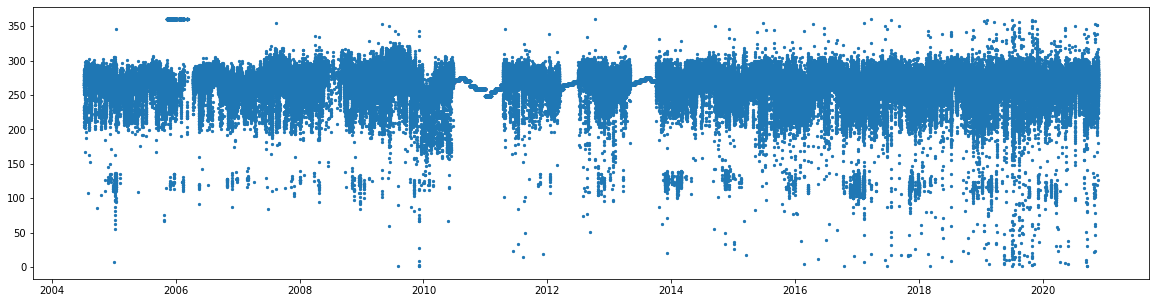

In [59]:
# Select same month from every year, calculate MWD mean
avg_jan = combined_adj[combined_adj['MWD degT'].index.month == 1].mean()
avg_feb = combined_adj[combined_adj['MWD degT'].index.month == 2].mean()
avg_mar = combined_adj[combined_adj['MWD degT'].index.month == 3].mean()
avg_apr = combined_adj[combined_adj['MWD degT'].index.month == 4].mean()
avg_may = combined_adj[combined_adj['MWD degT'].index.month == 5].mean()
avg_june = combined_adj[combined_adj['MWD degT'].index.month == 6].mean()
avg_july = combined_adj[combined_adj['MWD degT'].index.month == 7].mean()
avg_aug = combined_adj[combined_adj['MWD degT'].index.month == 8].mean()
avg_sep = combined_adj[combined_adj['MWD degT'].index.month == 9].mean()
avg_oct = combined_adj[combined_adj['MWD degT'].index.month == 10].mean()
avg_nov = combined_adj[combined_adj['MWD degT'].index.month == 11].mean()
avg_dec = combined_adj[combined_adj['MWD degT'].index.month == 12].mean()

display('Jan',avg_jan['MWD degT'])
display('Feb',avg_feb['MWD degT'])
display('Mar',avg_mar['MWD degT'])
display('Apr',avg_apr['MWD degT'])
display('May',avg_may['MWD degT'])
display('June',avg_june['MWD degT'])
display('July',avg_july['MWD degT'])
display('Aug',avg_aug['MWD degT'])
display('Sep',avg_sep['MWD degT'])
display('Oct',avg_oct['MWD degT'])
display('Nov',avg_nov['MWD degT'])
display('Dec',avg_dec['MWD degT'])

# Gap 1
combined_adj.loc['2010-6-23 18:30':'2010-6-30', 'MWD degT'] = 269.48060414158795
combined_adj.loc['2010-7-1':'2010-7-31', 'MWD degT'] = 272.0326848172483
combined_adj.loc['2010-8-1':'2010-8-31', 'MWD degT'] = 274.9308368551663
combined_adj.loc['2010-9-1':'2010-9-30', 'MWD degT'] = 270.15812299685547
combined_adj.loc['2010-10-1':'2010-10-31', 'MWD degT'] = 263.592741815509
combined_adj.loc['2010-11-1':'2010-11-30', 'MWD degT'] = 258.2181876313112
combined_adj.loc['2010-12-1':'2010-12-31', 'MWD degT'] = 259.2615381758332
combined_adj.loc['2011-1-1':'2011-1-31', 'MWD degT'] = 249.09921487308716
combined_adj.loc['2011-2-1':'2011-2-28', 'MWD degT'] = 254.63520535831876
combined_adj.loc['2011-3-1':'2011-3-31', 'MWD degT'] = 259.1872292739693
combined_adj.loc['2011-4-1':'2011-4-13 0:30', 'MWD degT'] = 265.13969792165835

# Gap 2
combined_adj.loc['2012-3-13 11:30':'2012-3-31', 'MWD degT'] = 259.1872292739693
combined_adj.loc['2012-4-1':'2012-4-30', 'MWD degT'] = 265.04762057806175
combined_adj.loc['2012-5-1':'2012-5-31', 'MWD degT'] = 266.6860922979911
combined_adj.loc['2012-6-1':'2012-6-30 23:30', 'MWD degT'] = 269.48060414158795

# Gap 3
combined_adj.loc['2013-5-3 20:30':'2013-5-31', 'MWD degT'] = 266.6860922979911
combined_adj.loc['2013-6-1':'2013-6-30', 'MWD degT'] = 269.48060414158795
combined_adj.loc['2013-7-1':'2013-7-31', 'MWD degT'] = 271.8615527219421
combined_adj.loc['2013-8-1':'2013-8-31', 'MWD degT'] = 275.19493448714184
combined_adj.loc['2013-9-1':'2013-9-30', 'MWD degT'] = 270.15812299685547
combined_adj.loc['2013-10-1':'2013-10-3 21:30', 'MWD degT'] = 263.592741815509

plt.figure(figsize=(20,5))
plt.scatter(x=combined_adj.index, y=combined_adj['MWD degT'], s=5)


In [60]:
# Calculations for Ubmax and bed shear stress for Neah Bay
calc = pd.DataFrame(index=combined_adj.index)

# Wavelength = (([g]*Wave Period^2/2*pi)*sqrt(tanh(4*pi^2*Water Depth)/Wave Period^2*[g]))
# λ = (([g]*P^2/2*pi)*sqrt(tanh(4*pi^2*d)/P^2*[g]))
calc['wavelength-inside tanh()'] = ((math.pi**2)*4*12.5)/((combined_adj['DPD sec']**2)*9.81)
calc['wavelength (m)'] = ((9.81*(combined_adj['DPD sec']**2))/(2*math.pi))*np.sqrt(np.tanh(calc['wavelength-inside tanh()']))
calc['ubmax (m/s)'] = (combined_adj['WVHT m']*9.81*combined_adj['DPD sec'])/(2*calc['wavelength (m)']*np.cosh((2*math.pi*12.5)/calc['wavelength (m)']))
calc['ubmax (cm/s)'] = calc['ubmax (m/s)']*100
calc['orbital excursion'] = (calc['ubmax (m/s)']*combined_adj['DPD sec'])/(2*math.pi)
calc['wave friction factor'] = pow(math.e, 5.213*pow(0.0025/calc['orbital excursion'],0.194)-5.977)   # the bed roughness value (ks) = 0.0025 m for the Elwha
calc['bed shear stress (Pa)'] = (2/(3*math.pi))*1017.1*calc['wave friction factor']*calc['ubmax (m/s)']**2   # density of seawater ρ = 1,017.1 kg/m3
display(calc)

,wavelength-inside tanh(),wavelength (m),ubmax (m/s),ubmax (cm/s),orbital excursion,wave friction factor,bed shear stress (Pa)
Date,,,,,,,
2004-07-09 00:00:00,1.627238,46.437216,0.144443,14.444293,0.127818,0.028811,0.129742
2004-07-09 01:00:00,0.724954,85.302955,0.516961,51.696102,0.685367,0.014660,0.845609
2004-07-09 02:00:00,0.264528,150.962787,0.562819,56.281896,1.235245,0.012130,0.829300
2004-07-09 03:00:00,0.724954,85.302955,0.500497,50.049729,0.663540,0.014823,0.801413
2004-07-09 04:00:00,0.724954,85.302955,0.431350,43.134964,0.571866,0.015609,0.626829
...,...,...,...,...,...,...,...
2020-11-23 12:30:00,0.342449,131.682675,0.904279,90.427942,1.744317,0.010961,1.934501
2020-11-23 13:00:00,0.342449,131.682675,0.877571,87.757074,1.692797,0.011055,1.837535
2020-11-23 13:30:00,0.302288,140.735139,0.814069,81.406852,1.671363,0.011095,1.586996


In [61]:
# Calculate WVHT, DPD, and wavelength from Neah Bay data and linear regression equations for long term Angeles Point time series 
#   LINEAR REGRESSION EQUATIONS CAN BE FOUND IN 'Elwha overlapping Neah Bay & Angeles Point (April-Nov 2020)' CODE FILE
ap_calc = pd.DataFrame(index=combined_adj.index)
ap_calc['calculated WVHT m for AP'] = (0.22*combined_adj['WVHT m'])+0.25
ap_calc['calculated DPD sec for AP'] = (0.41*combined_adj['DPD sec'])+4.53
ap_calc['calculated wavelength m for AP'] = (0.43*calc['wavelength (m)'])+43.13

# Next calculate Ubmax and bed shear stress using WVHT, DPD, and wavelength just calculated
ap_calc['ubmax (m/s)'] = (ap_calc['calculated WVHT m for AP']*9.81*ap_calc['calculated DPD sec for AP'])/(2*ap_calc['calculated wavelength m for AP']*np.cosh((2*math.pi*12.5)/ap_calc['calculated wavelength m for AP']))
ap_calc['ubmax (cm/s)'] = ap_calc['ubmax (m/s)']*100
ap_calc['orbital excursion'] = (ap_calc['ubmax (m/s)']*ap_calc['calculated DPD sec for AP'])/(2*math.pi)
ap_calc['wave friction factor'] = pow(math.e, 5.213*pow(0.0025/ap_calc['orbital excursion'],0.194)-5.977)   # the bed roughness value (ks) = 0.0025 m for the Elwha
ap_calc['bed shear stress (Pa)'] = (2/(3*math.pi))*1017.1*ap_calc['wave friction factor']*ap_calc['ubmax (m/s)']**2   # density of seawater ρ = 1,017.1 kg/m3
display(ap_calc)

,calculated WVHT m for AP,calculated DPD sec for AP,calculated wavelength m for AP,ubmax (m/s),ubmax (cm/s),orbital excursion,wave friction factor,bed shear stress (Pa)
Date,,,,,,,,
2004-07-09 00:00:00,0.4018,6.8096,63.098003,0.113135,11.313479,0.122613,0.029384,0.081176
2004-07-09 01:00:00,0.5954,7.9453,79.810271,0.190701,19.070082,0.241148,0.021741,0.170651
2004-07-09 02:00:00,0.5646,10.1839,108.043998,0.204562,20.456220,0.331558,0.019116,0.172649
2004-07-09 03:00:00,0.5844,7.9453,79.810271,0.187178,18.717763,0.236692,0.021911,0.165689
2004-07-09 04:00:00,0.5382,7.9453,79.810271,0.172380,17.238022,0.217981,0.022685,0.145493
...,...,...,...,...,...,...,...,...
2020-11-23 12:30:00,0.7714,9.4992,99.753550,0.271667,27.166675,0.410718,0.017608,0.280478
2020-11-23 13:00:00,0.7560,9.4992,99.753550,0.266243,26.624327,0.402518,0.017742,0.271445
2020-11-23 13:30:00,0.7120,9.8190,103.646110,0.254284,25.428392,0.397380,0.017828,0.248812


In [62]:
# Calculation for Angeles Point wavelength
#   This calculation was also done in 'Elwha overlapping Neah Bay & Angeles Point (April-Nov 2020)' code file and only uses actual Angeles Point data
wavelength_ap = pd.DataFrame(index=angeles_df.index)

# Wavelength = (([g]*Wave Period^2/2*pi)*sqrt(tanh(4*pi^2*Water Depth)/Wave Period^2*[g]))
# λ = (([g]*P^2/2*pi)*sqrt(tanh(4*pi^2*d)/P^2*[g]))
wavelength_ap['Angeles wavelength-inside tanh()'] = ((math.pi**2)*4*12.5)/((angeles_df['DPD sec']**2)*9.81)
wavelength_ap['Angeles wavelength (m)'] = ((9.81*(angeles_df['DPD sec']**2))/(2*math.pi))*np.sqrt(np.tanh(wavelength_ap['Angeles wavelength-inside tanh()']))
display(wavelength_ap)

,Angeles wavelength-inside tanh(),Angeles wavelength (m)
2020-04-01 19:00:00,0.453674,112.848718
2020-04-01 19:30:00,0.503038,106.410233
2020-04-01 20:00:00,0.453674,112.848718
2020-04-01 20:30:00,0.407542,119.791700
2020-04-01 21:00:00,0.407542,119.791700
...,...,...
2021-12-31 21:30:00,0.503038,106.410233
2021-12-31 22:00:00,0.555043,100.485507
2021-12-31 22:30:00,0.407542,119.791700
2021-12-31 23:00:00,0.407542,119.791700


[Text(0, 0.5, 'Wavelength (m)')]

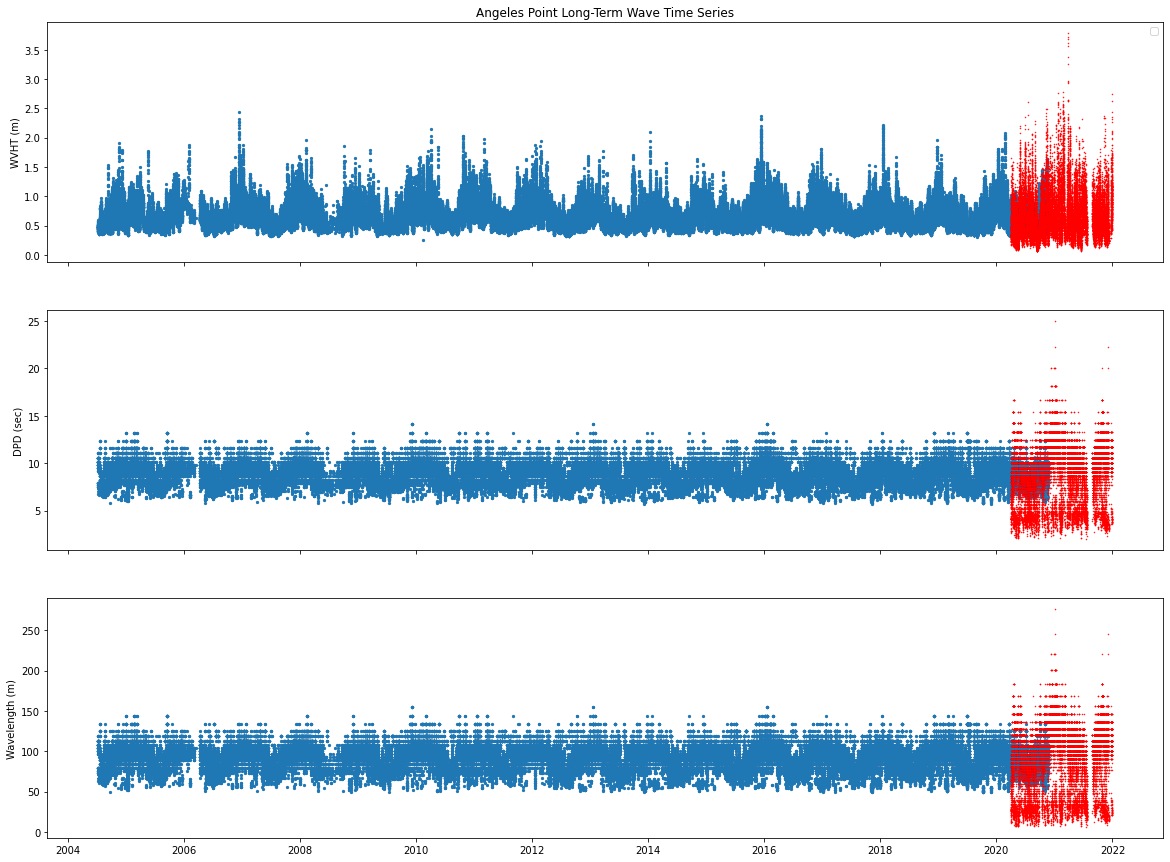

In [64]:
# Plot calculated WVHT, DPD, and wavelength for Angeles Point & actual data from Angeles Point

# Uncomment the time frames below to closely compare actual and calculated Angeles Point data
# angeles_df = angeles_df.loc[:'2020-11-23 14:30']
# calc = calc.loc['2020-04-01 19:00:00':'2020-11-23 14:30']
# wavelength_ap = wavelength_ap.loc[:'2020-11-23 14:30']

fig, (ax1, ax2, ax3) = plt.subplots(nrows=3, sharex=True, figsize=(20,15))

ax1.scatter(ap_calc.index, ap_calc['calculated WVHT m for AP'], s=5)
ax1.scatter(angeles_df.index, angeles_df['WVHT m'], s=0.25, c='red')
ax1.set(title='Angeles Point Long-Term Wave Time Series',
       ylabel='WVHT (m)')
ax1.legend()

ax2.scatter(ap_calc.index, ap_calc['calculated DPD sec for AP'], s=5)
ax2.scatter(angeles_df.index, angeles_df['DPD sec'], s=0.25, c='red')
ax2.set(ylabel='DPD (sec)')

ax3.scatter(ap_calc.index, ap_calc['calculated wavelength m for AP'], s=5)
ax3.scatter(wavelength_ap.index, wavelength_ap['Angeles wavelength (m)'], s=0.25, c='red')
ax3.set(ylabel='Wavelength (m)')


[Text(0, 0.5, 'τ$_{bw}$ (Pa)'), Text(0.5, 0, 'Date')]

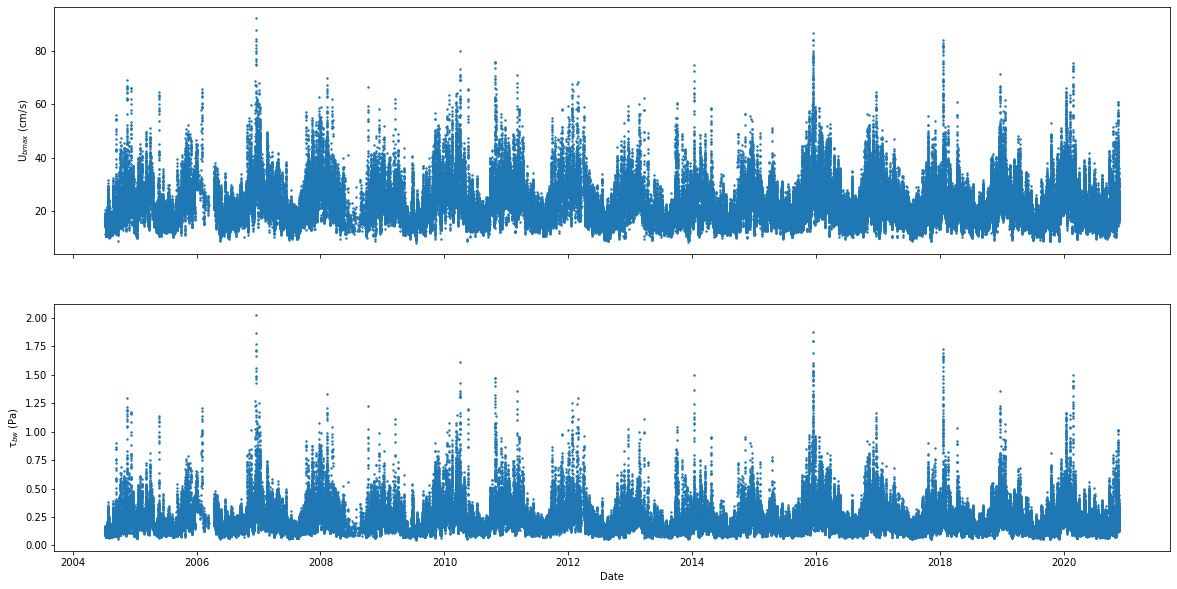

In [65]:
# Plot Ubmax and bed shear stress for Angeles Point long term wave series
fig, (ax1,ax2) = plt.subplots(nrows=2, sharex=True, figsize=(20,10))

ax1.scatter(ap_calc.index, ap_calc['ubmax (cm/s)'], s=2)
ax1.set( ylabel='U$_{bmax}$ (cm/s)') #title='Maximum wave-orbital velocity',

ax2.scatter(ap_calc.index, ap_calc['bed shear stress (Pa)'], s=2)
ax2.set(xlabel='Date', ylabel='τ$_{bw}$ (Pa)') #title='Bed shear stress', 

In [66]:
# Sum Ubmax (cm/s) between cruises
ubmax_one = ap_calc['ubmax (cm/s)'].loc[:'2016-10-13'].sum()
ubmax_two = ap_calc['ubmax (cm/s)'].loc['2016-10-14':'2017-6-6'].sum()
ubmax_three = ap_calc['ubmax (cm/s)'].loc['2017-6-7':'2017-8-1'].sum()
ubmax_four = ap_calc['ubmax (cm/s)'].loc['2017-8-2':'2018-10-12'].sum()
ubmax_five = ap_calc['ubmax (cm/s)'].loc['2018-10-12':].sum()


print(np.format_float_scientific(ubmax_one, precision = 2, exp_digits=2))
print(np.format_float_scientific(ubmax_two, precision = 2, exp_digits=2))
print(np.format_float_scientific(ubmax_three, precision = 2, exp_digits=2))
print(np.format_float_scientific(ubmax_four, precision = 2, exp_digits=2))
print(np.format_float_scientific(ubmax_five, precision = 2, exp_digits=2))


2.51e+06
2.77e+05
4.55e+04
4.37e+05
8.1e+05


In [67]:
# Sum bed shear stress (Pa) between cruises
τ_one = ap_calc['bed shear stress (Pa)'].loc[:'2016-10-13'].sum()
τ_two = ap_calc['bed shear stress (Pa)'].loc['2016-10-14':'2017-6-6'].sum()
τ_three = ap_calc['bed shear stress (Pa)'].loc['2017-6-7':'2017-8-1'].sum()
τ_four = ap_calc['bed shear stress (Pa)'].loc['2017-8-2':'2018-10-12'].sum()
τ_five = ap_calc['bed shear stress (Pa)'].loc['2018-10-12':].sum()


print(np.format_float_scientific(τ_one, precision = 2, exp_digits=2))
print(np.format_float_scientific(τ_two, precision = 2, exp_digits=2))
print(np.format_float_scientific(τ_three, precision = 2, exp_digits=2))
print(np.format_float_scientific(τ_four, precision = 2, exp_digits=2))
print(np.format_float_scientific(τ_five, precision = 2, exp_digits=2))

2.52e+04
2.85e+03
3.92e+02
4.17e+03
7.96e+03


[Text(0, 0.5, 'Wave Direction (degrees)'),
 Text(0.5, 0, 'Date'),
 Text(0.5, 1.0, 'Average Wave Direction (Coastal WA)')]

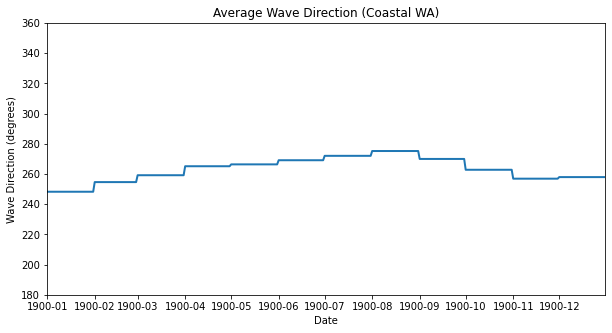

In [68]:
# Create plot of average wave direction values

# List of dates and the average wave direction for each month (average calculated previously)
data = [[1, 1, 248.25190905190902], [1, 31, 248.25190905190902], 
        [2, 1, 254.63520535831876], [2, 28, 254.63520535831876], 
        [3, 1, 259.1872292739693], [3, 31, 259.1872292739693], 
        [4, 1, 265.1396979216584], [4, 30, 265.1396979216584],
        [5, 1, 266.37643835239675], [5, 31, 266.37643835239675], 
        [6, 1, 269.1174724206794], [6, 30, 269.1174724206794], 
        [7, 1, 272.0326848172483], [7, 31, 272.0326848172483], 
        [8, 1, 275.2214136513712], [8, 31, 275.2214136513712], 
        [9, 1, 269.9723311996696], [9, 30, 269.9723311996696], 
        [10, 1, 262.80398191182013], [10, 31, 262.80398191182013], 
        [11, 1, 256.90512651265124], [11, 30, 256.90512651265124], 
        [12, 1, 257.946055259983], [12, 31, 257.946055259983]]
 
# Create the pandas DataFrame
df = pd.DataFrame(data, columns=['Month', 'Day', 'MWD degT'])
 
df['Date'] = df[['Month', 'Day']].astype(str).apply(lambda x: get_date_month_day(x.Month, x.Day), axis=1)
date_col = df.pop('Date')
df.insert(0, "Date", date_col)
df.loc[:,'Date'] = pd.to_datetime(df['Date'], format='%m-%d')

fig, ax = plt.subplots(figsize=(10,5))
ax.plot(df['Date'], df['MWD degT'], lw=2)
ax.set_xlim('1900-1-1','1900-12-31')
ax.set_ylim(180,360)
ax.set(xlabel="Date",
       ylabel="Wave Direction (degrees)",
       title="Average Wave Direction (Coastal WA)")